In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

2023-11-28 11:32:28.631359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Volumes/DataQ/Tugas Akhir/lstm-predict-potato-price/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# load data final preprocessing
pick_harga = 'KTG'
# load dataset csv harga 
df = pd.read_csv(f"data/timeseries-{pick_harga}-wonosobo.csv")

In [3]:
def normalize_data(df):
    scaler = MinMaxScaler()
    df['harga'] = scaler.fit_transform(df['harga'].values.reshape(-1,1))
    return df

df_new = normalize_data(df)
df_new = df_new['harga']

In [4]:
year = df['tanggal'].values
total  = df['harga'].values
year

array(['2021-01-01', '2021-01-02', '2021-01-03', ..., '2023-12-03',
       '2023-12-04', '2023-12-05'], dtype=object)

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(total, year, test_size=0.2, shuffle=False )
print(f"x train : {x_train.shape}" )
print(f"x validation : {x_valid.shape}")


x train : (844,)
x validation : (211,)


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

In [9]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [10]:
# Build the model
model = tf.keras.models.Sequential([
  LSTM(60, return_sequences=True),
  LSTM(60),
  Dense(30, activation="relu"),
  Dropout(0.5),
  Dense(10, activation="relu"),
  Dropout(0.2),
  Dense(1)
])

# # Print the model summary
# model.summary()

In [11]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [12]:
# Train the model
threshold_mae = (df['harga'].max() - df['harga'].min()) * 10/100
print(threshold_mae)

0.09999999999999998


In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
      print("\nMAE model sudah < 10% skala data")
      self.model.stop_training = True
callback = myCallback()

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)
history = model.fit(
    train_set,
    epochs=100, 
    validation_data=val_set,
    callbacks=[callback]
)

Epoch 1/100
8/8 [==============================] - 6s 203ms/step - loss: 0.1257 - mae: 0.3887 - val_loss: 0.1735 - val_mae: 0.5836
Epoch 2/100
8/8 [==============================] - 1s 100ms/step - loss: 0.1194 - mae: 0.3781 - val_loss: 0.1644 - val_mae: 0.5677
Epoch 3/100
8/8 [==============================] - 1s 88ms/step - loss: 0.1170 - mae: 0.3705 - val_loss: 0.1546 - val_mae: 0.5503
Epoch 4/100
8/8 [==============================] - 1s 87ms/step - loss: 0.1109 - mae: 0.3587 - val_loss: 0.1450 - val_mae: 0.5326
Epoch 5/100
8/8 [==============================] - 1s 88ms/step - loss: 0.1074 - mae: 0.3504 - val_loss: 0.1360 - val_mae: 0.5155
Epoch 6/100
8/8 [==============================] - 1s 94ms/step - loss: 0.1038 - mae: 0.3425 - val_loss: 0.1285 - val_mae: 0.5009
Epoch 7/100
8/8 [==============================] - 1s 120ms/step - loss: 0.0983 - mae: 0.3326 - val_loss: 0.1225 - val_mae: 0.4888
Epoch 8/100
8/8 [==============================] - 1s 93ms/step - loss: 0.0945 - mae: 0

In [98]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, None, 60)          14880     
                                                                 
 lstm_9 (LSTM)               (None, 60)                29040     
                                                                 
 dense_12 (Dense)            (None, 30)                1830      
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                310       
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                

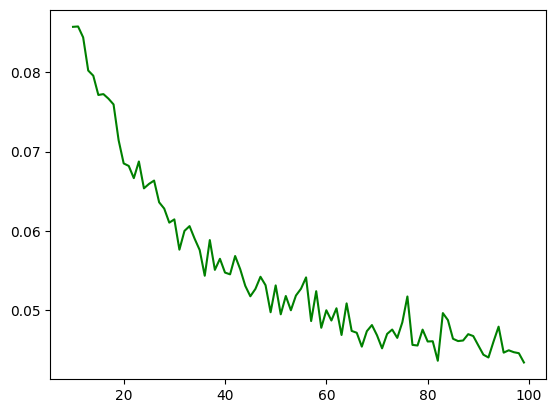

In [15]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'g', label='Training Loss')
plt.show()

In [19]:
pred = model.predict(df['harga'][0:60])
scaler = MinMaxScaler()
scaler.fit_transform(df['harga'])

scaler.inverse_transform(pred.reshape(-1,1))

2/2 [==============================] - 0s 9ms/step


ValueError: Expected 2D array, got 1D array instead:
array=[0.16666667 0.16666667 0.16666667 ... 0.5        0.5        0.5       ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [100]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [101]:
frc = model_forecast(model, x_train, window_size=60, batch_size=100)

8/8 [==============================] - 1s 44ms/step


In [102]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [113]:
forecast = model.predict(df_new[0:60])
forecast

2/2 [==============================] - 0s 12ms/step


array([[0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.21022086],
       [0.20881799],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.2074227 ],
       [0.2074227 ],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.20742269],
       [0.207